In [11]:
# Import modules
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [12]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['1', '0']

In [13]:
def clean_investment_grade(clean_csv_file):
    '''
    takes in the clean data set and transforms ratings into either investment grade or not investment grade
    '''
    df = pd.read_csv(clean_csv_file)
    
    d = {'AAA': 1, 'AA+': 2, 'AA': 3, 'AA-': 4, 'A+': 5, 'A': 6, 'A-': 7, 'BBB+': 8, 'BBB': 9,
            'BBB-': 10, 'BB+': 11, 'BB': 12, 'BB-': 13, 'B+': 14, 'B': 15, 'B-': 16, 'CCC+': 17,
            'CCC': 18, 'CCC-': 19, 'CC': 20, 'C': 21, 'SD': 22, 'D': 23}

    df = df.replace({'RTG_SP_LT_LC_ISSUER_CREDIT': d})
    
    # anything that is rated 10 or lower is investment grade, everything else is not
    for index, row in df.iterrows():
        if row['RTG_SP_LT_LC_ISSUER_CREDIT'] <= 10:
            df.at[index, 'RTG_SP_LT_LC_ISSUER_CREDIT'] = 1 # means investment grade
        else:
            df.at[index, 'RTG_SP_LT_LC_ISSUER_CREDIT'] = 0 # is not investment grade
            
    # everything should be good now
    df.to_csv('BDP_CLEAN_investment_grade.csv', index=False)

In [14]:
clean_investment_grade('BDP_CLEAN.csv')

In [33]:
# Import the data
CLEAN_DATAFILE = 'BDP_CLEAN_investment_grade.csv'
df = pd.read_csv(CLEAN_DATAFILE)

# Drop the identification columns
drop_columns = ['Ticker', 'Rating Date', 'Fiscal Year']
y_variable = 'RTG_SP_LT_LC_ISSUER_CREDIT'
df = df.drop(drop_columns, axis=1)
x = df.drop([y_variable], axis=1)
y = df[y_variable]

# There are 2 categorical predictor variables
# One hot encode the categorical data
x = pd.get_dummies(x)

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

# Dummy Classifier

In [16]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
dummy.fit(x_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [17]:
# Make predictions
y_pred = dummy.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.38      0.36      0.37       979
          1       0.66      0.68      0.67      1772

avg / total       0.56      0.57      0.56      2751



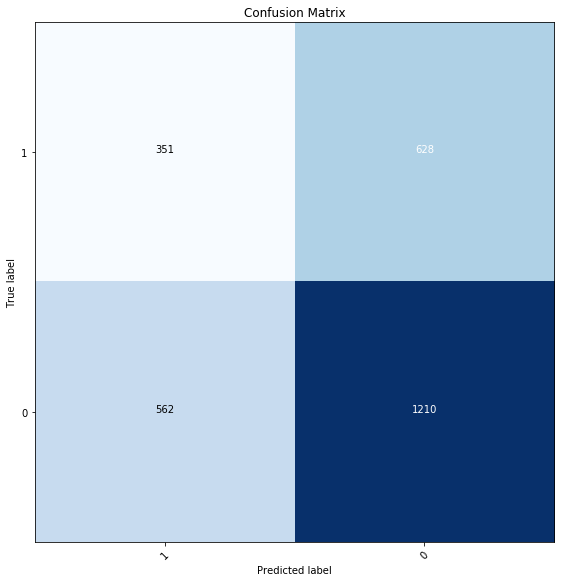

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.rcParams.update({'font.size':10})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()

# Tree Classifiers

## Random Forest

In [19]:
# Random Forest GridSearch
param_grid = {'n_estimators': np.arange(400, 1002, 200),
                'max_features': np.array(['sqrt', 'log2']),
                'max_depth': np.arange(10, 42, 4)}
forest_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

forest_grid.fit(x_train, y_train)
best_n = forest_grid.best_params_['n_estimators']
best_f = forest_grid.best_params_['max_features']
best_d = forest_grid.best_params_['max_depth']

print('Best n estimators: {}'.format(best_n))
print('Best max features: {}'.format(best_f))
print('Best max depth: {}'.format(best_d))

Best n estimators: 400
Best max features: sqrt
Best max depth: 34


In [20]:
# Store a dataframe with the results
rf_results = forest_grid.cv_results_
df = pd.DataFrame(rf_results)
df.to_csv('rf_results.csv', index=False)

In [34]:
# Fit the classifier with best params
rf = RandomForestClassifier(n_estimators=400, max_features='sqrt', max_depth=34)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=34, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
# Make predictions
y_pred = rf.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.88      0.75      0.81       979
          1       0.87      0.94      0.91      1772

avg / total       0.87      0.87      0.87      2751



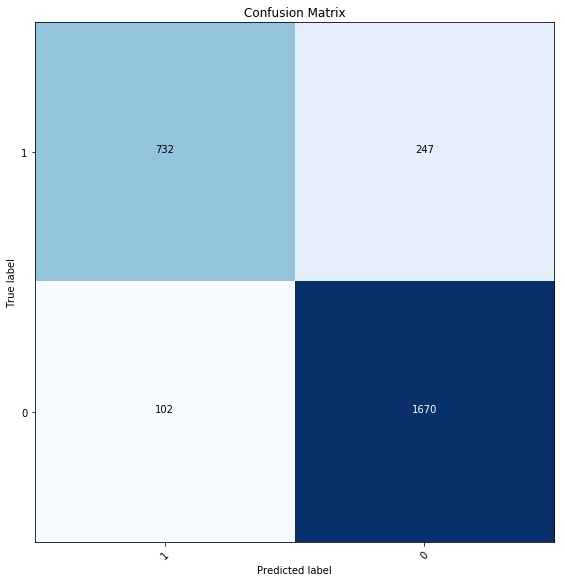

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.rcParams.update({'font.size':10})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()

## Adaboost

In [24]:
# Adaboost Gridsearch
param_grid = {'n_estimators': np.arange(200, 1002, 100),
                'learning_rate': np.arange(0.1, 1.1, 0.1)}
adaboost_grid = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5)

adaboost_grid.fit(x_train, y_train)
best_n = adaboost_grid.best_params_['n_estimators']
best_l = adaboost_grid.best_params_['learning_rate']

print('Best n estimators: {}'.format(best_n))
print('Best learning rate: {}'.format(best_l))

Best n estimators: 1000
Best learning rate: 0.2


In [37]:
# Fit the classifier with best params
ada_boost = AdaBoostClassifier(n_estimators=1000, learning_rate=0.2)
ada_boost.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.2, n_estimators=1000, random_state=None)

In [38]:
# Make predictions
y_pred = ada_boost.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.81      0.69      0.75       979
          1       0.84      0.91      0.88      1772

avg / total       0.83      0.83      0.83      2751



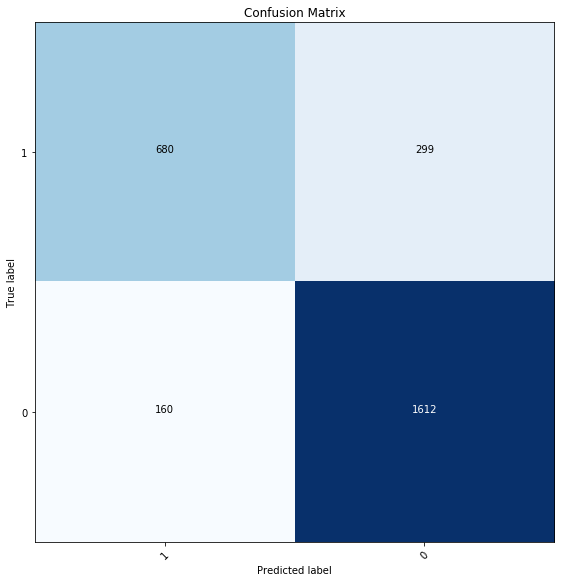

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.rcParams.update({'font.size':10})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()

# Neural Network

hidden_layer_sizes 400, max_iter 240, Average CV Error: 0.669584863033

In [28]:
# Neural Network

# Define parameters
PARAM_NAME_1 = 'hidden_layer_sizes'
PARAM_1 = np.arange(100,601,100)
PARAM_NAME_2 = 'max_iter'
PARAM_2 = np.arange(80,401,40)

# Perform classification
classifier = MLPClassifier()
param_grid = {PARAM_NAME_1: PARAM_1, PARAM_NAME_2: PARAM_2}
mlp_grid = GridSearchCV(classifier, param_grid, cv = 5).fit(x_train, y_train)

# Display tuned parameters
print(PARAM_NAME_1, mlp_grid.best_params_[PARAM_NAME_1])
print(PARAM_NAME_2, mlp_grid.best_params_[PARAM_NAME_2])

hidden_layer_sizes 300
max_iter 120


In [29]:
# Store a dataframe with the results
nn_results = mlp_grid.cv_results_
df = pd.DataFrame(nn_results)
df.to_csv('nn_results.csv', index=False)

In [40]:
# Fit the classifier with best params
classifier = MLPClassifier(hidden_layer_sizes=300, max_iter=120)
classifier.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=300, learning_rate='constant',
       learning_rate_init=0.001, max_iter=120, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [41]:
# Make predictions
predictions = classifier.predict(x_test)
report = classification_report(y_test, predictions)
print(report)

             precision    recall  f1-score   support

          0       0.78      0.70      0.74       979
          1       0.84      0.89      0.87      1772

avg / total       0.82      0.82      0.82      2751



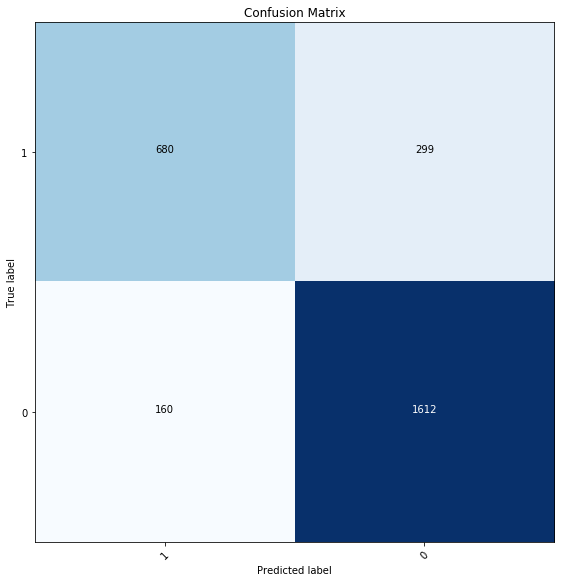

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.rcParams.update({'font.size':10})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()

### lets just really quickly see how a logistic regression would perform

In [43]:
from sklearn.linear_model import LogisticRegression

In [62]:
lr = LogisticRegression(C=100.0)
lr.fit(x_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
predictions = lr.predict(x_test)
report = classification_report(y_test, predictions)
print(report)

             precision    recall  f1-score   support

          0       0.76      0.64      0.70       979
          1       0.82      0.89      0.85      1772

avg / total       0.80      0.80      0.80      2751

